In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

In [85]:
# Loading the dataset
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [86]:
# Data visualisation and preprocessing
df.isna().sum() # Checking for NaN values

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [87]:
# Dropping article link column since it is not relevant
del df['article_link']

In [88]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


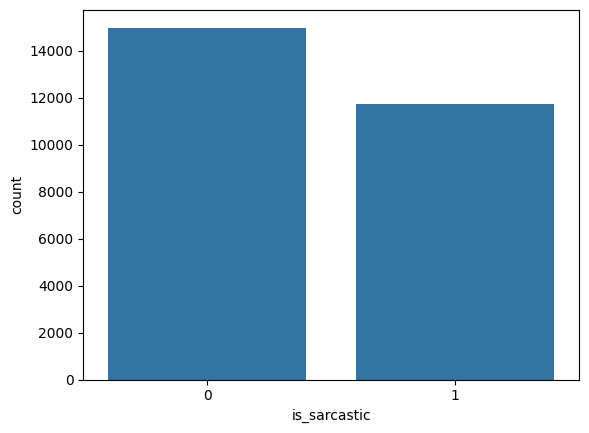

In [89]:
sns.countplot(x='is_sarcastic', data=df)
plt.show()

Some imbalance exists but this is manageable so we will proceed.

In [90]:
# stop words are words in the language that do not add much value to the sentence eg. the, have, he etc.
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import string

stop = set(stopwords.words('english'))  # standard English stopwords
punctuation = list(string.punctuation)  # ['!', '"', '#', ..., '?']
stop.update(punctuation)                # add punctuation to stopwords


[nltk_data] Downloading package stopwords to C:\Users\Indranil
[nltk_data]     Ghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
# Removing HTML tags from the text. BeautifulSoup parses the raw HTML text and get_text function returns only the visible text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)
# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords and punctuations from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

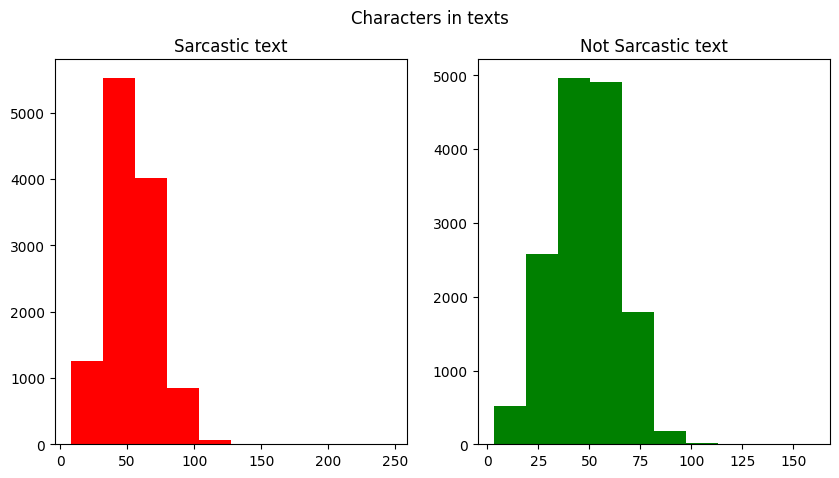

In [92]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

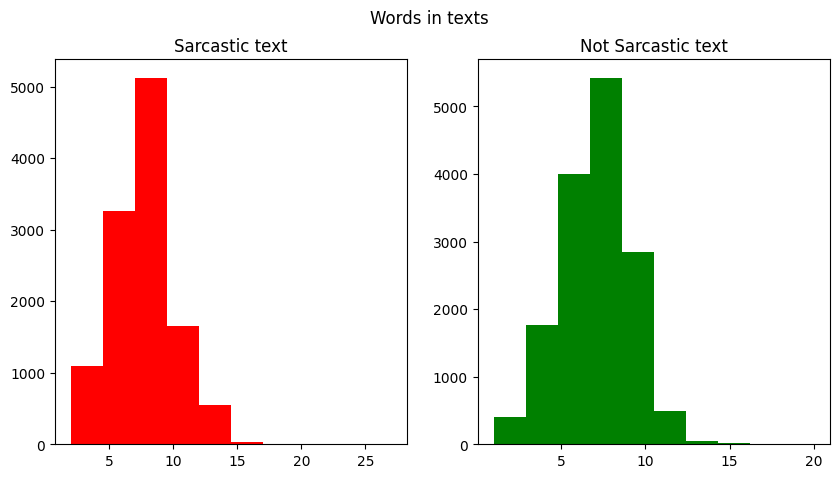

In [93]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

C:\Users\Indranil Ghosh\AppData\Local\Temp\ipykernel_16928\3382780483.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
C:\Users\Indranil Ghosh\AppData\Local\Temp\ipykernel_16928\3382780483.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(w

Text(0.5, 0.98, 'Average word length in each text')

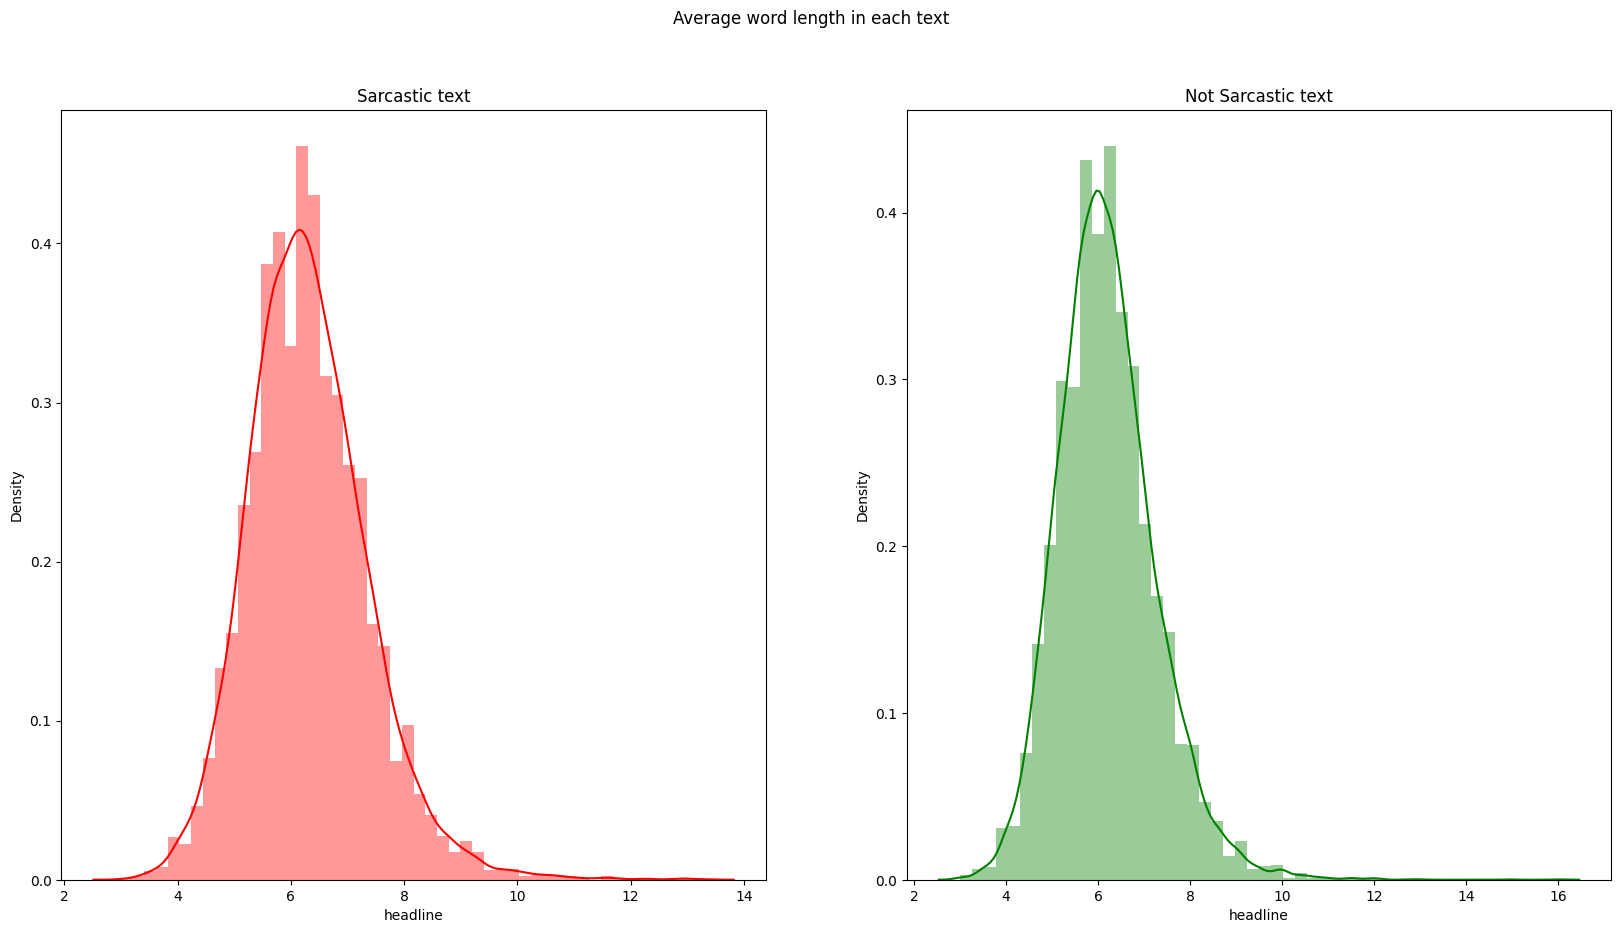

In [94]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

# word2vec and word embedding

In [95]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  "'black",
  "code'",
  'minority',
  'shoppers'],
 ["'roseanne'",
  'revival',
  'catches',
  'thorny',
  'political',
  'mood,',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  "son's",
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen,',
  'come',
  'alternative',
  'debt-reduction',
  'ideas'],
 ['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [96]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [97]:
#vocab size
len(w2v_model.wv)

36411

In [98]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [99]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [100]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [101]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [102]:
# Define Neural Network
model = Sequential()

# Embedding layer (non-trainable if you're using pre-trained vectors)
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_vectors],
    input_length=20,
    trainable=False  # Set to False if you want to freeze pre-trained embeddings
))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(
    units=128,
    recurrent_dropout=0.3,
    dropout=0.3,
    return_sequences=True
)))

# Bidirectional GRU layer
model.add(Bidirectional(GRU(
    units=32,
    recurrent_dropout=0.1,
    dropout=0.1
)))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # ✅ Use learning_rate instead of lr
    loss='binary_crossentropy',
    metrics=['acc']
)

# Free up memory
del embedding_vectors

C:\Users\Indranil Ghosh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [103]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     7,282,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,282,400 (27.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,282,400 (27.78 MB)

In [104]:
# Step 1: Split into train + temp (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(x, df.is_sarcastic, test_size=0.3, random_state=42)

# Step 2: Split temp into validation and test sets equally (or adjust sizes)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# appr 70% train and 15% of val and test each.

In [105]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=50,          
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 180ms/step - acc: 0.5724 - loss: 0.6838 - val_acc: 0.5637 - val_loss: 0.6988
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - acc: 0.5826 - loss: 0.6773 - val_acc: 0.5622 - val_loss: 0.6815
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - acc: 0.5995 - loss: 0.6667 - val_acc: 0.6181 - val_loss: 0.6476
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - acc: 0.6084 - loss: 0.6588 - val_acc: 0.6186 - val_loss: 0.6442
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - acc: 0.6195 - loss: 0.6449 - val_acc: 0.6233 - val_loss: 0.6348
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - acc: 0.6184 - loss: 0.6458 - val_acc: 0.6186 - val_loss: 0.6469
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - acc: 0.6220 - loss: 0.6434 - val_acc: 0.6251 - val_loss: 0.6310
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - acc: 0.6233 - loss: 0.6394 - val_acc: 0.6283 - val_loss: 0.6324
Epoch 9/50
147/147 ━━━━━━━━━━━━━

In [106]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - acc: 0.6319 - loss: 0.6287
Test Accuracy: 63.19%


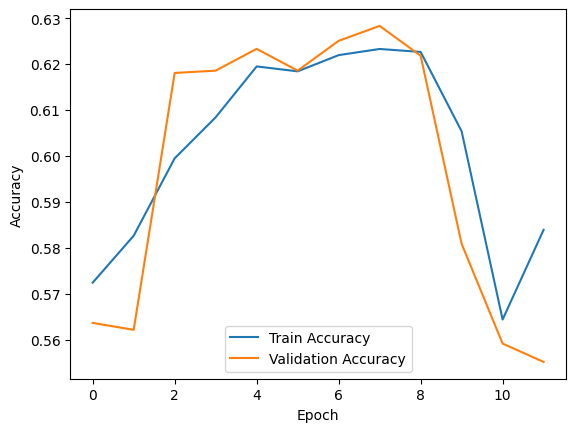

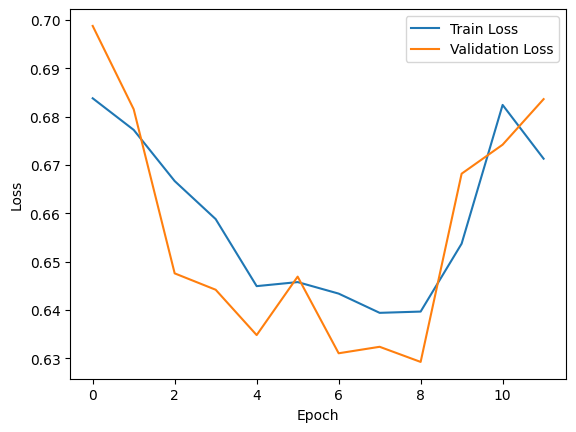

In [107]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step


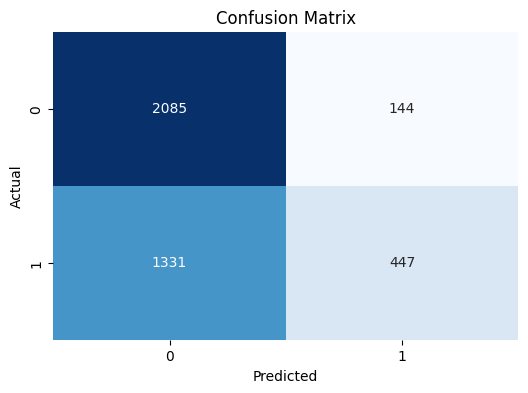

In [108]:
# Predict probabilities for test data
y_pred_prob = model.predict(x_test)

# Convert probabilities to binary class labels (0 or 1)
pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**GloVe** is a method that learns the meaning of words by looking at how often they appear near other words in a large text. It builds a table (called a co-occurrence matrix) that counts how frequently each word appears with every other word. Then, it compares the ratios of these counts to understand how words relate to each other. For example, "ice" appears more often with "solid" than "steam" does, while "steam" appears more with "gas". These patterns help GloVe create word vectors that capture real-world meanings and relationships between words.

In [109]:
# Data split
# Step 1: Split into train + temp (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(df.headline, df.is_sarcastic, test_size=0.3, random_state=42)

# Step 2: Split temp into validation and test sets equally
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
# Parameters
max_features = 35000
maxlen = 200
embed_size = 100  # GloVe file is 100d

In [110]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen)

x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen)

In [111]:
# Load GloVe
EMBEDDING_FILE = 'glove.6B.100d.txt'

In [112]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf8'))

In [113]:
# Prepare embedding matrix
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

all_embs = np.stack(list(embeddings_index.values()))
emb_mean, emb_std = all_embs.mean(), all_embs.std()

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [114]:
# Model
model = Sequential()
model.add(Embedding(input_dim=nb_words,
                    output_dim=embed_size,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))
model.add(Bidirectional(LSTM(units=128, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\Indranil Ghosh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [115]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     2,469,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,469,600 (9.42 MB)

 Trainable params: 2,469,600 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
x_val_seq = tokenizer.texts_to_sequences(x_val)     # tokenize validation text
x_val_pad = pad_sequences(x_val_seq, maxlen=maxlen) # pad to fixed length

In [117]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_pad, y_train,
    epochs=3,
    batch_size=128,
    validation_data=(x_val_pad, y_val),
    callbacks=[early_stop]
)

Epoch 1/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.7336 - loss: 0.5276 - val_accuracy: 0.8190 - val_loss: 0.4028
Epoch 2/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.8973 - loss: 0.2532 - val_accuracy: 0.8333 - val_loss: 0.4259
Epoch 3/3
147/147 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9591 - loss: 0.1122 - val_accuracy: 0.8195 - val_loss: 0.5825


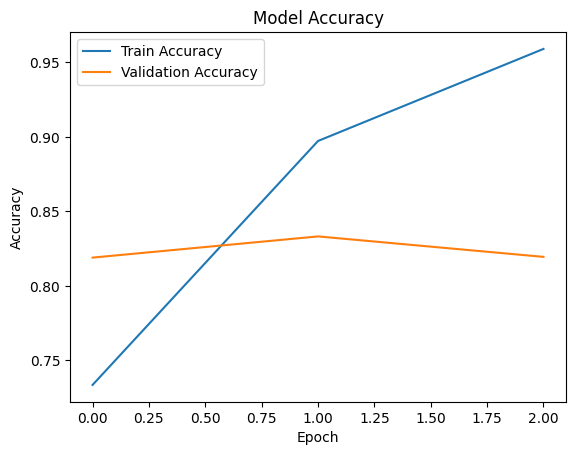

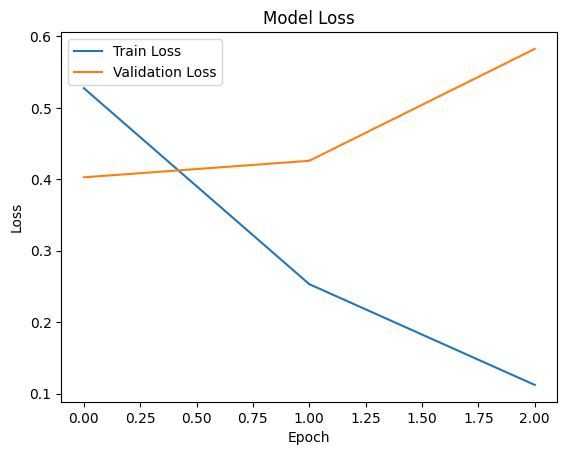

In [118]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      2229
           1       0.84      0.70      0.77      1778

    accuracy                           0.81      4007
   macro avg       0.82      0.80      0.80      4007
weighted avg       0.81      0.81      0.81      4007



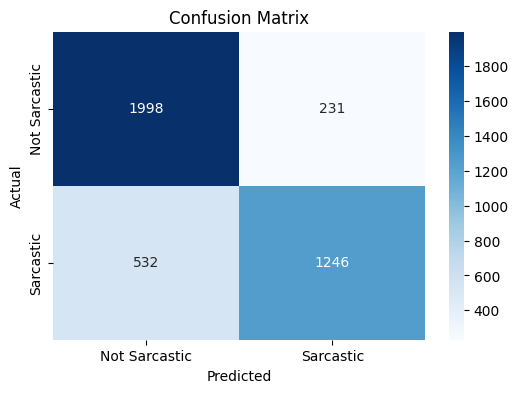

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict on test set
y_pred_probs = model.predict(x_test_pad)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()